# Feature generation models

### Tacotron2

In [1]:
# set path
trans_type = "phn"
dict_path = "downloads/en/tacotron2/data/lang_1phn/phn_train_no_dev_units.txt"
model_path = "downloads/en/tacotron2/exp/phn_train_no_dev_pytorch_train_tacotron2.v3_fastspeech.v4.single/results/model.last1.avg.best"

### FastSpeech

In [2]:
# set path
trans_type = "phn"
dict_path = "downloads/en/fastspeech/data/lang_1phn/phn_train_no_dev_units.txt"
model_path = "downloads/en/fastspeech/exp/phn_train_no_dev_pytorch_train_tacotron2.v3_fastspeech.v4.single/results/model.last1.avg.best"

### an4 - home trained

In [19]:
trans_type = "grph"
dict_path = "../../../espnet/egs/an4/tts1/data/lang_1char/train_nodev_units.txt"
model_path = "../../../espnet/egs/an4/tts1/exp/train_nodev_pytorch_train_pytorch_tacotron2_sample/results/model.loss.best"

# Vocoders

### Parallel wavegan

In [2]:
# set path
vocoder_path = "downloads/en/parallel_wavegan/ljspeech.parallel_wavegan.v2/checkpoint-400000steps.pkl"
vocoder_conf = "downloads/en/parallel_wavegan/ljspeech.parallel_wavegan.v2/config.yml"

### Setup

In [20]:
# add path
import sys
sys.path.append("espnet")

# define device
import torch
device = torch.device("cuda")


# define E2E-TTS model
from argparse import Namespace
from espnet.asr.asr_utils import get_model_conf
from espnet.asr.asr_utils import torch_load
from espnet.utils.dynamic_import import dynamic_import
idim, odim, train_args = get_model_conf(model_path)
model_class = dynamic_import(train_args.model_module)
model = model_class(idim, odim, train_args)
torch_load(model_path, model)
model = model.eval().to(device)
inference_args = Namespace(**{
    "threshold": 0.5,"minlenratio": 0.0, "maxlenratio": 10.0,
    # Only for Tacotron 2
    "use_attention_constraint": True, "backward_window": 1,"forward_window":3,
    # Only for fastspeech (lower than 1.0 is faster speech, higher than 1.0 is slower speech)
    "fastspeech_alpha": 1.0,
    })

# define neural vocoder
import yaml
import parallel_wavegan.models
with open(vocoder_conf) as f:
    config = yaml.load(f, Loader=yaml.Loader)
vocoder_class = config.get("generator_type", "ParallelWaveGANGenerator")
vocoder = getattr(parallel_wavegan.models, vocoder_class)(**config["generator_params"])
vocoder.load_state_dict(torch.load(vocoder_path, map_location="cpu")["model"]["generator"])
vocoder.remove_weight_norm()
vocoder = vocoder.eval().to(device)
if config["generator_params"]["out_channels"] > 1:
    from parallel_wavegan.layers import PQMF
    pqmf = PQMF(config["generator_params"]["out_channels"]).to(device)

# define text frontend
from tacotron_cleaner.cleaners import custom_english_cleaners
from g2p_en import G2p
with open(dict_path) as f:
    lines = f.readlines()
lines = [line.replace("\n", "").split(" ") for line in lines]
char_to_id = {c: int(i) for c, i in lines}
g2p = G2p()
def frontend(text):
    """Clean text and then convert to id sequence."""
    text = custom_english_cleaners(text)
    
    if trans_type == "phn":
        text = filter(lambda s: s != " ", g2p(text))
        text = " ".join(text)
        print(f"Cleaned text: {text}")
        charseq = text.split(" ")
    else:
        print(f"Cleaned text: {text}")
        charseq = list(text)
    idseq = []
    for c in charseq:
        if c.isspace():
            idseq += [char_to_id["<space>"]]
        elif c not in char_to_id.keys():
            idseq += [char_to_id["<unk>"]]
        else:
            idseq += [char_to_id[c]]
    idseq += [idim - 1]  # <eos>
    return torch.LongTensor(idseq).view(-1).to(device)

import nltk
nltk.download('punkt')
print("Now ready to synthesize!")

Now ready to synthesize!


[nltk_data] Downloading package punkt to
[nltk_data]     /home/dariocazzani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Synthesis

In [22]:
import time
print("Input your favorite sentence in English!")
input_text = input()
pad_fn = torch.nn.ReplicationPad1d(
    config["generator_params"].get("aux_context_window", 0))
use_noise_input = vocoder_class == "ParallelWaveGANGenerator"
with torch.no_grad():
    start = time.time()
    x = frontend(input_text)
    c, _, _ = model.inference(x, inference_args)
    c = pad_fn(c.unsqueeze(0).transpose(2, 1)).to(device)
    xx = (c,)
    mel_output = xx
    if use_noise_input:
        z_size = (1, 1, (c.size(2) - sum(pad_fn.padding)) * config["hop_size"])
        z = torch.randn(z_size).to(device)
        xx = (z,) + xx
    if config["generator_params"]["out_channels"] == 1:
        y = vocoder(*xx).view(-1)
    else:
        y = pqmf.synthesis(vocoder(*xx)).view(-1)    
rtf = (time.time() - start) / (len(y) / config["sampling_rate"])
print(f"RTF = {rtf:5f}")
from IPython.display import display, Audio
audio = y.view(-1).cpu().numpy()
display(Audio(audio, rate=config["sampling_rate"]))

Input your favorite sentence in English!
one two three
Cleaned text: ONE TWO THREE
RTF = 0.087698


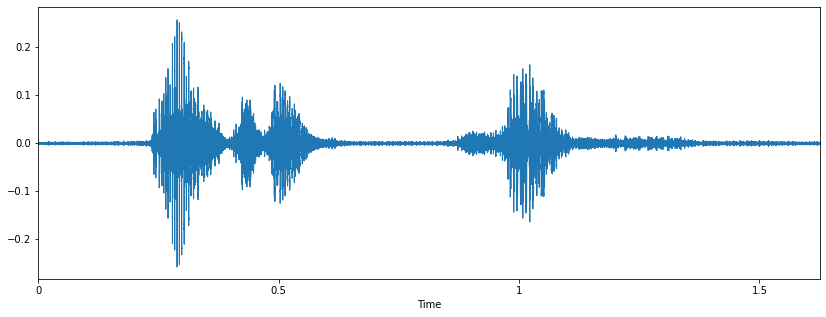

In [23]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio, sr=config["sampling_rate"])

In [24]:
import numpy as np
%matplotlib inline
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd

sr = 8000
mel_output_numpy = np.squeeze(mel_output[0].cpu().numpy())
print(mel_output_numpy.shape)

(80, 144)


In [25]:
audio_inv = librosa.feature.inverse.mel_to_audio(mel_output_numpy, sr=config["sampling_rate"], hop_length=config["hop_size"])

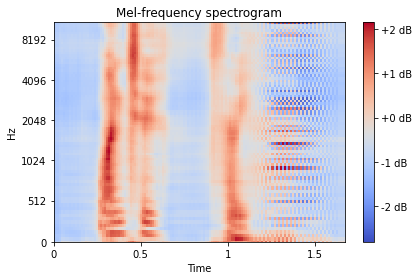

In [26]:
librosa.display.specshow(mel_output_numpy, x_axis='time', y_axis='mel', sr=config["sampling_rate"], fmax=config["sampling_rate"]/2, hop_length=config["hop_size"])
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [27]:
display(Audio(audio_inv, rate=config["sampling_rate"]))

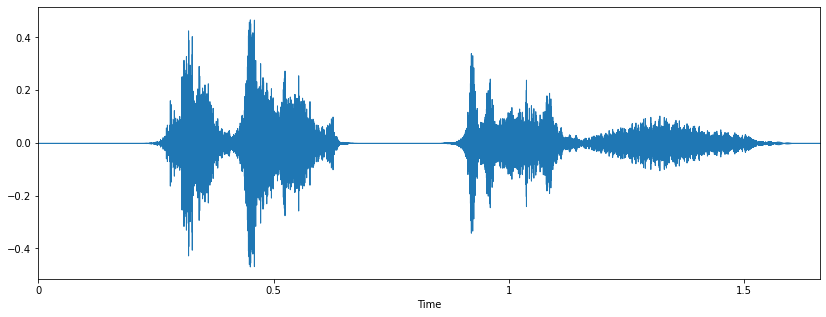

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio_inv, sr=config["sampling_rate"])